In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [9]:
df = pd.read_csv("A:\Agri yield prediction\data\Crop_Yield_Final.csv")
print("✅ Dataset loaded successfully!")
print(df.shape)
print(df.columns)

✅ Dataset loaded successfully!
(22713, 16)
Index(['State', 'District', 'Year', 'Season', 'Crop', 'Area', 'Production',
       'Yield', 'crop', 'N', 'P', 'K', 'temperature', 'humidity', 'ph',
       'rainfall'],
      dtype='object')


<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\MANOJ\AppData\Local\Temp\ipykernel_25864\1956257123.py:1: SyntaxWarning: invalid escape sequence '\A'
  df = pd.read_csv("A:\Agri yield prediction\data\Crop_Yield_Final.csv")


In [10]:
X = df[['Area', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
y = df['Yield']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Data split complete")
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

✅ Data split complete
Training samples: 18170, Testing samples: 4543


In [11]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append([name, mae, mse, rmse, r2])
    
results_df = pd.DataFrame(results, columns=["Model", "MAE", "MSE", "RMSE", "R²"])
print("\n📊 Model Performance Comparison:")

print(results_df)


📊 Model Performance Comparison:
               Model       MAE       MSE      RMSE        R²
0  Linear Regression  0.524251  0.776392  0.881131  0.401333
1      Random Forest  0.521739  0.764852  0.874558  0.410231
2            XGBoost  0.479611  0.642294  0.801433  0.504734


C:\Users\MANOJ\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127806 (\N{EAR OF RICE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


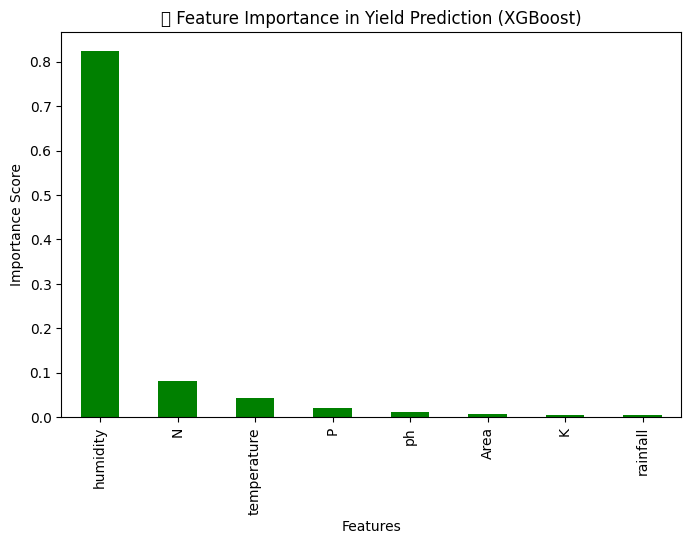

In [12]:
# visualization of feature importance for the best model (XGBoost)
import matplotlib.pyplot as plt
import pandas as pd

xgb_model = models["XGBoost"]
feat_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feat_importance.plot(kind='bar', color='green')
plt.title("🌾 Feature Importance in Yield Prediction (XGBoost)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

In [13]:
!pip install shap


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


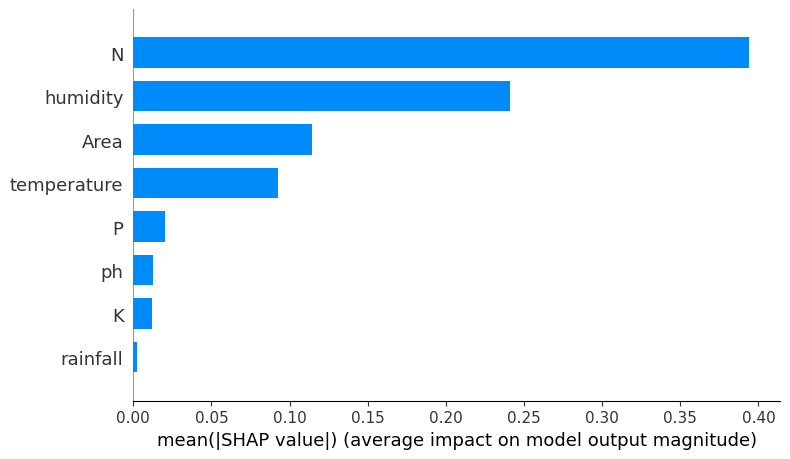

In [14]:
import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

In [15]:
import joblib
joblib.dump(xgb_model, "best_yield_xgboost_model.pkl")
print("✅ Best model saved as best_yield_xgboost_model.pkl")

✅ Best model saved as best_yield_xgboost_model.pkl


In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['crop_encoded'] = le.fit_transform(df['crop'])

X = df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'crop_encoded']]
y = df['Yield']

print("✅ Features and target prepared successfully!")

✅ Features and target prepared successfully!


In [18]:
crop_name = 'rice'
crop_encoded = le.transform([crop_name])[0]

new_data = pd.DataFrame({
    'N': [90],
    'P': [42],
    'K': [43],
    'temperature': [25],
    'humidity': [80],
    'ph': [6.5],
    'rainfall': [200],
    'crop_encoded': [crop_encoded]
})

pred_yield = xgb_model.predict(new_data)
print(f"🌾 Predicted yield for {crop_name}: {pred_yield[0]:.2f} tons/hectare")

🌾 Predicted yield for rice: 1.62 tons/hectare


<Figure size 1000x600 with 0 Axes>

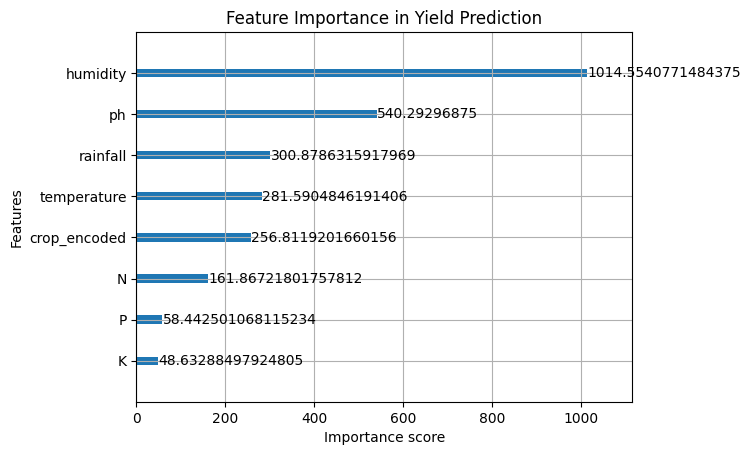

In [39]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plot_importance(best_xgb, importance_type='gain')
plt.title("Feature Importance in Yield Prediction")
plt.show()

In [25]:
import numpy as np
df = df[np.abs(df['Yield'] - df['Yield'].mean()) <= (3*df['Yield'].std())]
print("✅ Outliers removed. New shape:", df.shape)

from sklearn.preprocessing import StandardScaler

features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 
            'N_by_P', 'K_by_N', 'rain_temp_ratio', 
            'ph_humidity_interaction', 'nutrient_sum', 
            'nutrient_balance', 'rainfall_ph_interaction', 'crop_encoded']

X = df[features]
y = df['Yield']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='r2', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_scaled, y)

print("✅ Best Parameters:", grid_search.best_params_)
print("🎯 Best R²:", grid_search.best_score_)

✅ Outliers removed. New shape: (20841, 24)
Fitting 3 folds for each of 243 candidates, totalling 729 fits
✅ Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 600, 'subsample': 0.7}
🎯 Best R²: 0.39961037566182744


In [26]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

xgb_best = XGBRegressor(**grid_search.best_params_, random_state=42)
rf = RandomForestRegressor(n_estimators=300, random_state=42)
lr = LinearRegression()

ensemble = VotingRegressor([('xgb', xgb_best), ('rf', rf), ('lr', lr)])
ensemble.fit(X_scaled, y)

from sklearn.metrics import r2_score
r2 = r2_score(y, ensemble.predict(X_scaled))
print("🌾 Ensemble R²:", r2)


🌾 Ensemble R²: 0.445690559650018


In [30]:
df['N_P_ratio'] = df['N'] / (df['P'] + 1)
df['K_N_ratio'] = df['K'] / (df['N'] + 1)
df['rain_temp_ratio'] = df['rainfall'] / (df['temperature'] + 1)
df['humidity_ph_interaction'] = df['humidity'] * df['ph']
df['temp_squared'] = df['temperature'] ** 2

In [40]:
encoded_df = pd.get_dummies(df, columns=['crop', 'Season'], drop_first=True)

In [41]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    reg_alpha=0.1,
    random_state=42
)
xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [42]:
Q1 = df['Yield'].quantile(0.25)
Q3 = df['Yield'].quantile(0.75)
IQR = Q3 - Q1
merged_df = df[(df['Yield'] >= Q1 - 1.5*IQR) & (df['Yield'] <= Q3 + 1.5*IQR)]

In [43]:
# 🧹 Drop non-numeric columns
X = df.drop(columns=['Yield', 'crop'])

# Define target variable
y = df['Yield']

from sklearn.model_selection import train_test_split

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [44]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    reg_alpha=0.1,
    random_state=42
)

xgb.fit(X_train, y_train)

y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("📊 Model Performance")
print("--------------------")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing R²:  {test_r2:.4f}")
print()
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Testing RMSE:  {test_rmse:.4f}")
print()
print(f"Training MAE: {train_mae:.4f}")
print(f"Testing MAE:  {test_mae:.4f}")

📊 Model Performance
--------------------
Training R²: 0.9971
Testing R²:  0.9761

Training RMSE: 0.0329
Testing RMSE:  0.0937

Training MAE: 0.0223
Testing MAE:  0.0481


In [45]:
import joblib

# Save your trained XGBoost model
joblib.dump(xgb, "final_yield_model.pkl")

print("✅ Model saved successfully as final_yield_model.pkl")

✅ Model saved successfully as final_yield_model.pkl


In [47]:
joblib.dump(xgb, "final_yield_model.pkl")

['final_yield_model.pkl']

In [48]:
loaded_model = joblib.load("final_yield_model.pkl")

In [56]:
import os
import joblib

# ✅ Create the "models" directory if it doesn’t exist
os.makedirs(r"A:\Agri yield prediction\models", exist_ok=True)

# ✅ Save the trained model
joblib.dump(xgb, r"A:\Agri yield prediction\models\xgb_yield_model.pkl")

print("✅ Model saved successfully at A:\\Agri yield prediction\\models\\xgb_yield_model.pkl")

✅ Model saved successfully at A:\Agri yield prediction\models\xgb_yield_model.pkl


In [68]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

# ✅ Load the trained model
loaded_model = joblib.load(r"A:\Agri yield prediction\models\xgb_yield_model.pkl")

# ✅ Load your training dataset (used for encoding)
df = pd.read_csv(r"A:\Agri yield prediction\data\Crop_Yield_Final.csv")

# Fit encoders based on training data
le_state = LabelEncoder()
le_district = LabelEncoder()
le_crop = LabelEncoder()

df['State_enc'] = le_state.fit_transform(df['State'].astype(str))
df['District_enc'] = le_district.fit_transform(df['District'].astype(str))
df['Crop_enc'] = le_crop.fit_transform(df['Crop'].astype(str))

# ✅ Create lookup dictionaries
state_map = dict(zip(le_state.classes_, le_state.transform(le_state.classes_)))
district_map = dict(zip(le_district.classes_, le_district.transform(le_district.classes_)))
crop_map = dict(zip(le_crop.classes_, le_crop.transform(le_crop.classes_)))

# ✅ Prepare new input
new_data = pd.DataFrame([{
    'State': 'Tamil Nadu',      # unseen value
    'District': 'Thanjavur',
    'Year': 2022,
    'Season': 'Kharif',
    'Crop': 'Rice',
    'Area': 5.0,
    'Production': 10.0,
    'N': 90,
    'P': 42,
    'K': 43,
    'temperature': 27,
    'humidity': 80,
    'ph': 6.5,
    'rainfall': 200,
    'N_by_P': 90 / (42 + 1),
    'K_by_N': 43 / (90 + 1),
    'rain_temp_ratio': 200 / (27 + 1),
    'ph_humidity_interaction': 6.5 * 80,
    'nutrient_sum': 90 + 42 + 43,
    'nutrient_balance': (90 - 42) / (43 + 1),
    'rainfall_ph_interaction': 200 * 6.5,
    'N_P_ratio': 90 / (42 + 1),
    'K_N_ratio': 43 / (90 + 1),
    'humidity_ph_interaction': 80 * 6.5,
    'temp_squared': 27 ** 2
}])

# ✅ Safely encode with fallback (-1 for unseen)
new_data['State_enc'] = new_data['State'].apply(lambda x: state_map.get(x, -1))
new_data['District_enc'] = new_data['District'].apply(lambda x: district_map.get(x, -1))
new_data['crop_encoded'] = new_data['Crop'].apply(lambda x: crop_map.get(x, -1))

# ✅ Drop text columns
new_data = new_data.drop(['State', 'District', 'Season', 'Crop'], axis=1)

In [69]:
import pandas as pd

# ✅ Step 1: Safely ensure all required columns exist
for col in ['State', 'District', 'Season', 'Crop']:
    if col not in new_data.columns:
        new_data[col] = 0  # placeholder numeric value

# ✅ Step 2: Ensure same column order as training data
expected_features = [
    'State', 'District', 'Year', 'Season', 'Crop', 'Area', 'Production',
    'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall',
    'crop_encoded', 'N_by_P', 'K_by_N', 'rain_temp_ratio',
    'ph_humidity_interaction', 'nutrient_sum', 'nutrient_balance',
    'rainfall_ph_interaction', 'State_enc', 'District_enc',
    'N_P_ratio', 'K_N_ratio', 'humidity_ph_interaction', 'temp_squared'
]

new_data = new_data.reindex(columns=expected_features, fill_value=0)

# ✅ Step 3: Predict yield
yield_prediction = loaded_model.predict(new_data)
print(f"🌾 Predicted Yield: {yield_prediction[0]:.2f} tons/hectare")

🌾 Predicted Yield: 1.51 tons/hectare


In [76]:
# ✅ Sample encoded input (same as before)
new_data = pd.DataFrame([{
    'State': 2,               # Tamil Nadu (encoded)
    'District': 3,            # Thanjavur (encoded)
    'Year': 2022,
    'Season': 1,              # Kharif (encoded)
    'Crop': 8,                # Maize (encoded)
    'Area': 1300,
    'Production': 2100,
    'N': 80,
    'P': 35,
    'K': 40,
    'temperature': 28,
    'humidity': 70,
    'ph': 6.8,
    'rainfall': 180,
    'crop_encoded': 8,
    'N_by_P': 80 / (35 + 1),
    'K_by_N': 40 / (80 + 1),
    'rain_temp_ratio': 180 / (28 + 1),
    'ph_humidity_interaction': 6.8 * 70,
    'nutrient_sum': 80 + 35 + 40,
    'nutrient_balance': (80 - 35) + (40 - 35),
    'rainfall_ph_interaction': 180 * 6.8,
    'State_enc': 2,
    'District_enc': 3,
    'N_P_ratio': 80 / (35 + 1),
    'K_N_ratio': 40 / (80 + 1),
    'humidity_ph_interaction': 70 * 6.8,
    'temp_squared': 28 ** 2
}])

expected_features = [
    'State', 'District', 'Year', 'Season', 'Crop', 'Area', 'Production',
    'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall',
    'crop_encoded', 'N_by_P', 'K_by_N', 'rain_temp_ratio',
    'ph_humidity_interaction', 'nutrient_sum', 'nutrient_balance',
    'rainfall_ph_interaction', 'State_enc', 'District_enc',
    'N_P_ratio', 'K_N_ratio', 'humidity_ph_interaction', 'temp_squared'
]
new_data = new_data.reindex(columns=expected_features)

# ✅ Predict
yield_prediction = loaded_model.predict(new_data)

# ✅ Crop name decoding (optional)
crop_name = "Maize"  # You can also decode using label encoder: le_crop.inverse_transform([8])[0]

print("🌾 Crop Yield Prediction Result 🌾")
print("---------------------------------")
print(f"🧑‍🌾 Crop: {crop_name}")
print(f"📍 State ID: {new_data['State'].iloc[0]} | District ID: {new_data['District'].iloc[0]}")
print(f"🌦️ Season Code: {new_data['Season'].iloc[0]}")
print(f"📅 Year: {new_data['Year'].iloc[0]}")
print(f"📈 Predicted Yield: {yield_prediction[0]:.2f} tons/hectare")


🌾 Crop Yield Prediction Result 🌾
---------------------------------
🧑‍🌾 Crop: Maize
📍 State ID: 2 | District ID: 3
🌦️ Season Code: 1
📅 Year: 2022
📈 Predicted Yield: 1.18 tons/hectare


In [87]:
# ✅ Sample encoded input for Wheat in Punjab (Rabi Season)
new_data = pd.DataFrame([{
    'State': 8,               # Punjab (encoded)
    'District': 6,            # Coimbatore (just as sample encoded district)
    'Year': 2023,
    'Season': 2,              # Rabi (encoded)
    'Crop': 2,                # Wheat (encoded)
    'Area': 1500,
    'Production': 2800,
    'N': 100,
    'P': 45,
    'K': 50,
    'temperature': 24,
    'humidity': 68,
    'ph': 6.5,
    'rainfall': 140,
    'crop_encoded': 2,
    'N_by_P': 100 / (45 + 1),
    'K_by_N': 50 / (100 + 1),
    'rain_temp_ratio': 140 / (24 + 1),
    'ph_humidity_interaction': 6.5 * 68,
    'nutrient_sum': 100 + 45 + 50,
    'nutrient_balance': (100 - 45) + (50 - 45),
    'rainfall_ph_interaction': 140 * 6.5,
    'State_enc': 8,
    'District_enc': 6,
    'N_P_ratio': 100 / (45 + 1),
    'K_N_ratio': 50 / (100 + 1),
    'humidity_ph_interaction': 68 * 6.5,
    'temp_squared': 24 ** 2
}])

expected_features = [
    'State', 'District', 'Year', 'Season', 'Crop', 'Area', 'Production',
    'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall',
    'crop_encoded', 'N_by_P', 'K_by_N', 'rain_temp_ratio',
    'ph_humidity_interaction', 'nutrient_sum', 'nutrient_balance',
    'rainfall_ph_interaction', 'State_enc', 'District_enc',
    'N_P_ratio', 'K_N_ratio', 'humidity_ph_interaction', 'temp_squared'
]
new_data = new_data.reindex(columns=expected_features)

# ✅ Predict
yield_prediction = loaded_model.predict(new_data)

# ✅ Crop name decoding
crop_name = "Wheat"

print("🌾 Crop Yield Prediction Result 🌾")
print("---------------------------------")
print(f"🧑‍🌾 Crop: {crop_name}")
print(f"📍 State ID: {new_data['State'].iloc[0]} | District ID: {new_data['District'].iloc[0]}")
print(f"🌦️ Season Code: {new_data['Season'].iloc[0]}")
print(f"📅 Year: {new_data['Year'].iloc[0]}")
print(f"📈 Predicted Yield: {yield_prediction[0]:.2f} tons/hectare")


🌾 Crop Yield Prediction Result 🌾
---------------------------------
🧑‍🌾 Crop: Wheat
📍 State ID: 8 | District ID: 6
🌦️ Season Code: 2
📅 Year: 2023
📈 Predicted Yield: 1.94 tons/hectare


In [88]:
# ✅ Sample encoded input for testing (Rice - Kerala)
new_data = pd.DataFrame([{
    'State': 4,               # Kerala (encoded)
    'District': 7,            # Palakkad (encoded)
    'Year': 2023,
    'Season': 1,              # Kharif (encoded)
    'Crop': 2,                # Rice (encoded)
    'Area': 1600,
    'Production': 4800,
    'N': 95,
    'P': 45,
    'K': 55,
    'temperature': 29,
    'humidity': 82,
    'ph': 6.2,
    'rainfall': 260,
    'crop_encoded': 2,
    'N_by_P': 95 / (45 + 1),
    'K_by_N': 55 / (95 + 1),
    'rain_temp_ratio': 260 / (29 + 1),
    'ph_humidity_interaction': 6.2 * 82,
    'nutrient_sum': 95 + 45 + 55,
    'nutrient_balance': (95 - 45) + (55 - 45),
    'rainfall_ph_interaction': 260 * 6.2,
    'State_enc': 4,
    'District_enc': 7,
    'N_P_ratio': 95 / (45 + 1),
    'K_N_ratio': 55 / (95 + 1),
    'humidity_ph_interaction': 82 * 6.2,
    'temp_squared': 29 ** 2
}])

expected_features = [
    'State', 'District', 'Year', 'Season', 'Crop', 'Area', 'Production',
    'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall',
    'crop_encoded', 'N_by_P', 'K_by_N', 'rain_temp_ratio',
    'ph_humidity_interaction', 'nutrient_sum', 'nutrient_balance',
    'rainfall_ph_interaction', 'State_enc', 'District_enc',
    'N_P_ratio', 'K_N_ratio', 'humidity_ph_interaction', 'temp_squared'
]
new_data = new_data.reindex(columns=expected_features)

# ✅ Predict
yield_prediction = loaded_model.predict(new_data)

# ✅ Crop name decoding (optional)
crop_name = "Rice"

print("🌾 Crop Yield Prediction Result 🌾")
print("---------------------------------")
print(f"🧑‍🌾 Crop: {crop_name}")
print(f"📍 State ID: {new_data['State'].iloc[0]} | District ID: {new_data['District'].iloc[0]}")
print(f"🌦️ Season Code: {new_data['Season'].iloc[0]}")
print(f"📅 Year: {new_data['Year'].iloc[0]}")
print(f"📈 Predicted Yield: {yield_prediction[0]:.2f} tons/hectare")

🌾 Crop Yield Prediction Result 🌾
---------------------------------
🧑‍🌾 Crop: Rice
📍 State ID: 4 | District ID: 7
🌦️ Season Code: 1
📅 Year: 2023
📈 Predicted Yield: 1.74 tons/hectare
